Epoch 1/300


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.3823 - mae: 0.4523 - val_loss: 0.1543 - val_mae: 0.3008
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1896 - mae: 0.3264 - val_loss: 0.1563 - val_mae: 0.2974
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1697 - mae: 0.3117 - val_loss: 0.1299 - val_mae: 0.2734
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1655 - mae: 0.3075 - val_loss: 0.1949 - val_mae: 0.3369
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1639 - mae: 0.3055 - val_loss: 0.1632 - val_mae: 0.3031
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1637 - mae: 0.3077 - val_loss: 0.1250 - val_mae: 0.2714
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1659 - mae: 0.3042 - val_loss: 0.1821 - val_mae: 0.3272
Epoch 8/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1592 - mae: 0.3025 - val_loss: 0.1425 - val_mae: 0.2884
Epoch 9/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1553 -

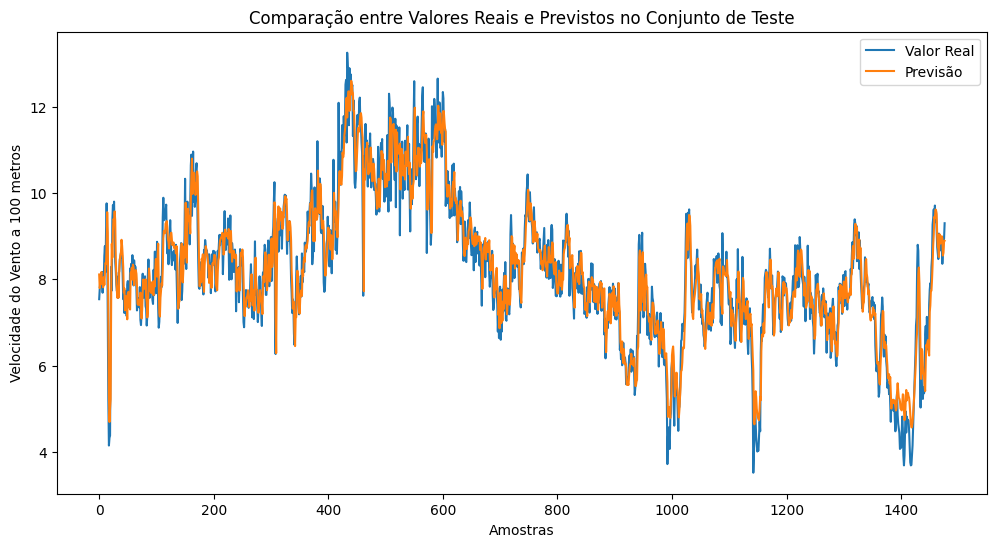

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


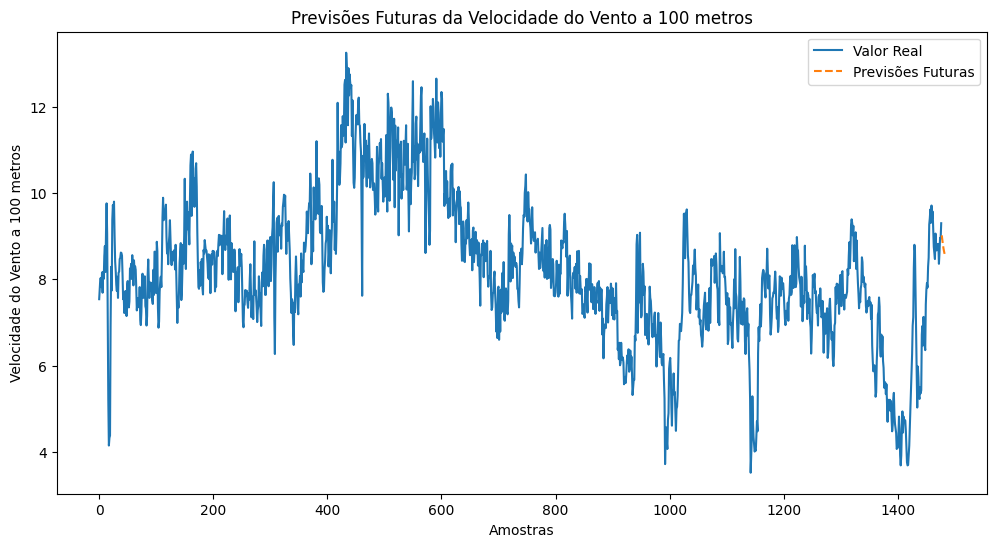

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Carregar dados
data = pd.read_csv("dataset.csv")

# Converter 'id' em datetime e definir como índice
data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Selecionar variáveis
variables = data[['ws100', 'humid', 'temp', 'wdisp100']].values

# Tratar valores ausentes
variables = variables[~np.isnan(variables).any(axis=1)]

# Padronização dos dados
scaler = StandardScaler()
variables_scaled = scaler.fit_transform(variables)

# Parâmetros
sequence_length = 36
split_ratio = 0.8

# Divisão dos dados em treinamento e teste
split_index = int(len(variables_scaled) * split_ratio)
train_data = variables_scaled[:split_index]
test_data = variables_scaled[split_index:]

# Função para preparar sequências de dados
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # 'ws100' é o alvo
    return np.array(X), np.array(y)

# Criar sequências para treinamento e teste
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Obter média e desvio padrão de 'ws100' para inversão da padronização
mean_ws100 = scaler.mean_[0]
std_ws100 = np.sqrt(scaler.var_[0])

# Definição da função de perda MAPE
def mape_loss(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

# Construção do modelo aprimorado
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compilação do modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Avaliação do modelo no conjunto de teste
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Previsão no conjunto de teste
y_pred = model.predict(X_test).flatten()

# Inversão da padronização das previsões e valores reais
y_pred_inv = y_pred * std_ws100 + mean_ws100
y_test_inv = y_test * std_ws100 + mean_ws100

# Cálculo das métricas de desempenho
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE no teste: {mae}")
print(f"RMSE no teste: {rmse}")
print(f"MAPE no teste: {mape}")

# Plotagem das previsões vs valores reais no conjunto de teste
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valor Real')
plt.plot(y_pred_inv, label='Previsão')
plt.legend()
plt.title('Comparação entre Valores Reais e Previstos no Conjunto de Teste')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()

# Função recursiva para prever passos futuros
def recursive_forecast(model, initial_sequence, steps=6):
    predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        predicted = model.predict(current_sequence.reshape(1, sequence_length, -1))[0, 0]
        predictions.append(predicted)
        
        # Manter as outras variáveis constantes (último valor observado)
        last_observed = current_sequence[-1, 1:]
        new_observation = np.hstack([predicted, last_observed])
        current_sequence = np.vstack([current_sequence[1:], new_observation])
    
    return np.array(predictions)

# Utilizar a última sequência do conjunto de teste para previsão futura
last_sequence = test_data[-sequence_length:]

# Previsão de passos futuros
future_steps = 6
predictions_scaled = recursive_forecast(model, last_sequence, steps=future_steps)

# Inversão da padronização das previsões futuras
predictions_inv = predictions_scaled * std_ws100 + mean_ws100

# Plotagem das previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valor Real')
plt.plot(range(len(y_test_inv), len(y_test_inv) + future_steps), predictions_inv, label='Previsões Futuras', linestyle='--')
plt.legend()
plt.title('Previsões Futuras da Velocidade do Vento a 100 metros')
plt.xlabel('Amostras')
plt.ylabel('Velocidade do Vento a 100 metros')
plt.show()
